In [1]:
# import dependencies for training
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable
import tqdm

In [10]:
# load and inspect the dataset
# Read the CSV file
df = pd.read_csv('dataset/forest_dataset.csv')

# Remove "dataset/" from the paths in the "imageT0" and "imageT1" columns
#df['imageT0'] = df['imageT0'].str.replace('dataset/', '')
#df['imageT1'] = df['imageT1'].str.replace('dataset/', '')

# Display the modified DataFrame
print(df)

                       imageT0                    imageT1  label
0      dataset/forestT0_0.jpeg    dataset/forestT1_0.jpeg      0
1      dataset/forestT0_1.jpeg    dataset/forestT1_1.jpeg      0
2      dataset/forestT0_2.jpeg    dataset/forestT1_2.jpeg      0
3      dataset/forestT0_3.jpeg    dataset/forestT1_3.jpeg      0
4      dataset/forestT0_4.jpeg    dataset/forestT1_4.jpeg      0
..                         ...                        ...    ...
195  dataset/forestT0_195.jpeg  dataset/forestT1_195.jpeg      1
196  dataset/forestT0_196.jpeg  dataset/forestT1_196.jpeg      1
197  dataset/forestT0_197.jpeg  dataset/forestT1_197.jpeg      1
198  dataset/forestT0_198.jpeg  dataset/forestT1_198.jpeg      1
199  dataset/forestT0_199.jpeg  dataset/forestT1_199.jpeg      1

[200 rows x 3 columns]


In [11]:
# Split the dataset into training and testing sets

subfolder = '~/training-zkml/dataset'
subfolder = os.path.expanduser(subfolder)


#image1_paths = [os.path.join(subfolder, path) for path in df['imageT0'].tolist()]
#image2_paths = [os.path.join(subfolder, path) for path in df['imageT1'].tolist()]
image1_paths = df['imageT0'].tolist()
image2_paths = df['imageT1'].tolist()
labels = df['label'].tolist()


train_image1_paths, test_image1_paths, train_image2_paths, test_image2_paths, train_labels, test_labels = train_test_split(
    image1_paths, image2_paths, labels, test_size=0.2, random_state=42
)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [39]:
class ForestDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, labels, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img1 = Image.open(self.image1_paths[idx]).convert('L')
        img2 = Image.open(self.image2_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)


        return img1, img2, label

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((10, 10)),
    transforms.ToTensor(),
])


# Create datasets and dataloaders
train_dataset = ForestDataset(train_image1_paths, train_image2_paths, train_labels, transform=transform)
test_dataset = ForestDataset(test_image1_paths, test_image2_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)



In [45]:
# Define the Siamese neural network
class SiameseBambooNN(nn.Module):
    def __init__(self):
        super(SiameseBambooNN, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.fc = nn.Linear(16, 1)  # Output 1 for similar, 0 for dissimilar

    def forward_one(self, x):
        x = x.view(-1, 1, 10, 10)  # Reshape input for convolutional layer
        return self.embedding_net(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        distance = torch.abs(output1 - output2)
        output = self.fc(distance)
        return output


In [53]:
# TRAIN THE MODEL
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
#from defineSNN import SiameseBambooNN
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseBambooNN().to(device)

# Display the network architecture
#print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

#criterion = torch.nn.BCEWithLogitsLoss()
criterion = ContrastiveLoss(margin=5)


# Training loop
num_epochs = 10
learning_rates = [10, 5, 2, 0.1, 0.01]
avg_losses = {lr: [] for lr in learning_rates}
accuracies = {lr: [] for lr in learning_rates}

for lr in learning_rates:

    #optimizer =  optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    #scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):

        total_loss = 0
        total_batches = 0
        model.train()

        for batch in train_loader:
            img1, img2, label = batch
            #print(img1.size())
            #print(img2.size())
            #print(label.size())

            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            finalout = model(img1, img2)
            output1 = model.forward_one(img1)
            output2 = model.forward_one(img2)

            labels = torch.zeros_like(finalout)
            labels[label.view(-1, 1) == 1] = 1
            #loss = criterion(finalout, labels.float())
            loss = criterion(output1, output2, label.float())


            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_batches += 1

                  # Print intermediate sizes for debugging
            #print("output1 size:", output1.size())
            #print("output2 size:", output2.size())
            #print("finalout size:", finalout.size())

        #scheduler.step()
        average_loss = total_loss / total_batches
        avg_losses[lr].append(average_loss)
        print(f'Learning Rate: {lr}, Avg loss: {average_loss}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for batch in test_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            finalout = model(img1, img2)
            predicted_labels = (torch.sigmoid(finalout) > 0.5).float()

            total += label.size(0)
            correct += (predicted_labels.view(-1) == label).sum().item()

        accuracy = correct / total
        accuracies[lr].append(accuracy)
        print(f'Learning Rate: {lr}, Test Accuracy: {accuracy * 100:.2f}%')


    # save just params
    torch.save(model.state_dict(), f'trained_simplesnn_lr_{lr}.pth')


Total number of parameters: 3393
Learning Rate: 10, Avg loss: 12.595916658639908
Learning Rate: 10, Avg loss: 12.579426348209381
Learning Rate: 10, Avg loss: 12.562208473682404
Learning Rate: 10, Avg loss: 12.538665562868118
Learning Rate: 10, Avg loss: 12.50819543004036
Learning Rate: 10, Avg loss: 12.464218139648438
Learning Rate: 10, Avg loss: 12.402453273534775
Learning Rate: 10, Avg loss: 12.313358396291733
Learning Rate: 10, Avg loss: 12.185254007577896
Learning Rate: 10, Avg loss: 12.02415418624878
Learning Rate: 10, Test Accuracy: 47.50%
Learning Rate: 5, Avg loss: 11.873670905828476
Learning Rate: 5, Avg loss: 11.781647324562073
Learning Rate: 5, Avg loss: 11.713756114244461
Learning Rate: 5, Avg loss: 11.651672542095184
Learning Rate: 5, Avg loss: 11.622123956680298
Learning Rate: 5, Avg loss: 11.553238809108734
Learning Rate: 5, Avg loss: 11.500688016414642
Learning Rate: 5, Avg loss: 11.451973706483841
Learning Rate: 5, Avg loss: 11.35559594631195
Learning Rate: 5, Avg loss

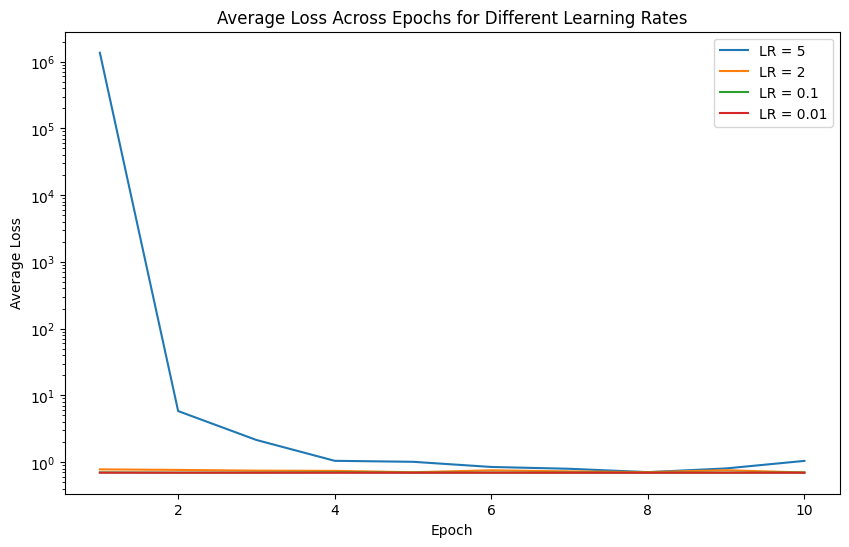

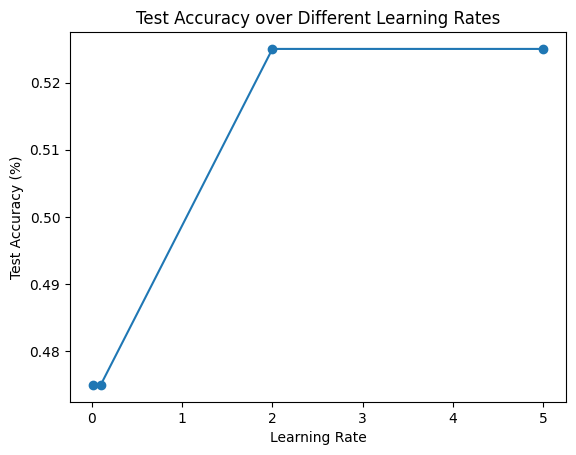

In [43]:
# Plotting the average loss for each learning rate
plt.figure(figsize=(10, 6))
for lr, losses in avg_losses.items():
    plt.plot(range(1, num_epochs + 1), losses, label=f'LR = {lr}')

plt.title('Average Loss Across Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Average Loss')
plt.legend()
# Set axis limits
#plt.xlim(1, 8)
#plt.ylim(0, 4)
plt.show()

# Plotting accuracies over learning rates
lr_values = [lr for lr in learning_rates]
accuracy_values = [accuracies[lr][-1] for lr in learning_rates]
plt.plot(lr_values, accuracy_values, marker='o', linestyle='-')
#plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Different Learning Rates')
plt.show()